# Potential Talents - An Apziva Project (#3)

# EDA

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

## Imports and Helper Functions

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
from datetime import datetime
import json
from pathlib import Path
import inspect
import re
import string
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import geopandas as gpd
import duckdb
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics.pairwise import cosine_similarity

In [119]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.corpus import stopwords # lists of stopwords
from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer # basic stemmer
from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/sra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [218]:
from gensim.models import Word2Vec, KeyedVectors

In [120]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [121]:
seed=rand_gen()
seed

3764

In [122]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x30AC41040

In [123]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

Read in the datset:

In [124]:
df=pd.read_csv('../data/3_data.csv')
df.head(3)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


## Analysis

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


No nulls in the dataset. That is nice for us! There are 104 total observations.

In [126]:
df['fit'].value_counts()

Series([], Name: count, dtype: int64)

We'll remove `fit` as it is a column with no data.

In [127]:
if 'fit' in df.columns: # flow control for repeat code executions
    df.drop('fit',axis=1,inplace=True)

df.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


Inspect the connections column:

In [128]:
connections=df['connection'].value_counts()

connections

connection
500+     44
85        7
61        7
44        6
1         5
2         4
4         2
7         2
57        2
390       2
103       1
48        1
18        1
71        1
19        1
415       1
9         1
64        1
39        1
155       1
349       1
174       1
40        1
50        1
268       1
455       1
52        1
409       1
212       1
16        1
5         1
82        1
49        1
Name: count, dtype: int64

I will change the "500+" into 500 so that it can remain a numeric value.

In [129]:
# remove all non-numeric characters from the column
column='connection'
if not pd.api.types.is_numeric_dtype(df[column]):
    df[column]=df[column].str.replace(r'\D','',regex=True)

    # check if any '+' characters are still present
    print("Amount of '+' in column:",df[column].str.contains(r'\+').sum())

    # convert to integer
    df[column]=pd.to_numeric(df[column],errors='coerce')
    print(df.dtypes)

    # check if conversion was successful
    print('\nWas conversion successful?')
    if pd.api.types.is_numeric_dtype(df[column]):
        print('Yes.')
    else:
        print('No.')
else:
    print(f'There are no non-numeric characters in the column: {column}')

Amount of '+' in column: 0
id             int64
job_title     object
location      object
connection     int64
dtype: object

Was conversion successful?
Yes.


### Histogram of Connections

In [130]:
# remove the >500 connection observations
df_no500 = df[df['connection']<500]

# check
df_no500['connection'].value_counts().head(3)

connection
85    7
61    7
44    6
Name: count, dtype: int64

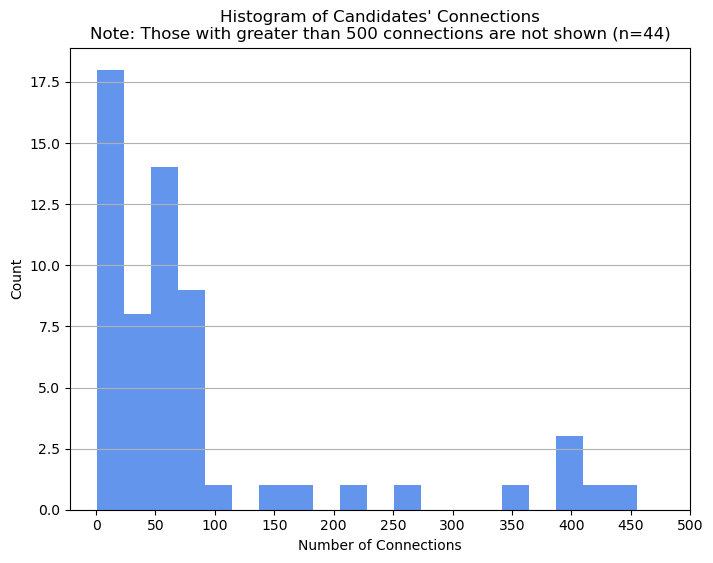

In [131]:
plt.figure(figsize=(8,6))
plt.hist(x=df_no500['connection'],
         color='cornflowerblue',
         bins=20)
plt.title("Histogram of Candidates' Connections\nNote: Those with greater than 500 connections are not shown (n=44)")
plt.xlabel('Number of Connections')
plt.ylabel('Count')
plt.grid(which='both',axis='y')
plt.xticks(range(0,501,50)) # get xticks to appear every 50 connections

plt.savefig('figures/3_histogram_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.png',bbox_inches='tight')

plt.show()

### Boxplot of Connections

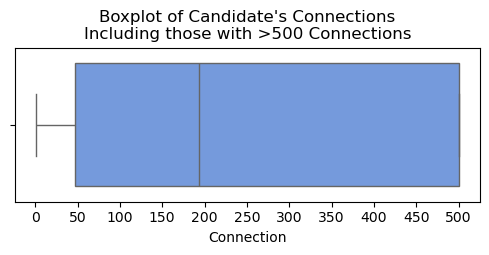

In [132]:
plt.figure(figsize=(6,2))
sns.boxplot(x=df['connection'],color='cornflowerblue')
plt.title("Boxplot of Candidate's Connections\nIncluding those with >500 Connections")
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.png',bbox_inches='tight')

plt.show()

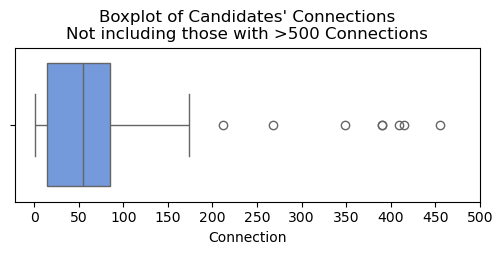

In [133]:
plt.figure(figsize=(6,2))
plt.tight_layout()
sns.boxplot(x=df_no500['connection'],color='cornflowerblue')
plt.title("Boxplot of Candidates' Connections\nNot including those with >500 Connections")
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_no500.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.png',bbox_inches='tight')

plt.show()

### Map of Observations

In [134]:
df['location'].value_counts()

location
Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Chicago, Illinois                       2
Austin, Texas Area                      2
Greater Atlanta Area                    2
Amerika Birleşik Devletleri             2
Long Beach, California                  1
Milpitas, California                    1
Greater Chicago Area                    1
Torrance, California                    1
Greater Los Angeles Area                1
Bridgewater, Massachusetts              1
Lafayette, Indiana                      1
Kokomo, Indiana Area                    1
Las Vegas, Nevada Area   

In [135]:
# number of unique locations in dataset
df['location'].nunique()

41

This is not terrible. I'd like to get the location for each municipality to create a chloropleth map of the locations.

First step is to clean this column to make it easier to get the locations. We won't go fully intense with the geospatial information, so if the city says "Greater CITY Area," I'll just make that "CITY" to simplify things.

In [136]:
# data from here:
# https://github.com/kelvins/US-Cities-Database
cities=pd.read_csv('../data/us_cities.csv')
cities.head(3)

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
0,1,AK,Alaska,Adak,Aleutians West,55.999722,-161.207778
1,2,AK,Alaska,Akiachak,Bethel,60.891854,-161.392330
2,3,AK,Alaska,Akiak,Bethel,60.890632,-161.199325


In [137]:
# find cities
_=cities[cities['CITY'].str.contains('Katy')]
_

# I also used Google Earth Pro

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
25488,25489,TX,Texas,Katy,Fort Bend,29.750893,-95.811675
25489,25490,TX,Texas,Katy,Harris,29.819922,-95.729267


In [138]:
city_loc_map={
    'Kanada':{'lat':45.424721,'lon':-75.695,'name':'Canada'}, # choosing Ottowa
    'Raleigh-Durham, North Carolina Area':{'lat':35.772701,'lon':-78.632439,'name':'Raleigh'},
    'Houston, Texas Area':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Greater New York City Area':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'Houston, Texas':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Denton, Texas':{'lat':33.22893,'lon':-97.131436,'name':'Denton'},
    'San Francisco Bay Area':{'lat':37.775,'lon':-122.4183,'name':'San_Francisco'},
    'Greater Philadelphia Area':{'lat':39.864998,'lon':-75.275196,'name':'Philadelphia'},
    'İzmir, Türkiye':{'lat':38.4228,'lon':27.1404,'name':'İzmir'},
    'Lake Forest, California':{'lat':33.640015,'lon':-117.68819,'name':'Lake_Forest_CA'},
    'Atlanta, Georgia':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Chicago, Illinois':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Austin, Texas Area':{'lat':30.2303,'lon':-97.7144,'name':'Austin'},
    'Greater Atlanta Area':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Amerika Birleşik Devletleri':{'lat':39.833333,'lon':-98.583333,'name':'United_States'},
    'Long Beach, California':{'lat':33.7705,'lon':-118.1885,'name':'Long_Beach'},
    'Milpitas, California':{'lat':37.436491,'lon':-121.892885,'name':'Milpitas'},
    'Greater Chicago Area':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Torrance, California':{'lat':33.826817,'lon':-118.31183,'name':'Torrance'},
    'Greater Los Angeles Area':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Bridgewater, Massachusetts':{'lat':41.977341,'lon':-70.97234,'name':'Bridgewater_MA'},
    'Lafayette, Indiana':{'lat':40.417743,'lon':-86.888358,'name':'Lafayette_IN'},
    'Kokomo, Indiana Area':{'lat':40.498840,'lon':-86.145273,'name':'Kokomo_IN'},
    'Las Vegas, Nevada Area':{'lat':36.172082,'lon':-115.122366,'name':'Las_Vegas'},
    'Cape Girardeau, Missouri':{'lat':37.31685,'lon':-89.545861,'name':'Cape_Girardeau'},
    'Gaithersburg, Maryland':{'lat':39.14187,'lon':-77.188993,'name':'Gaithersburg'},
    'Baltimore, Maryland':{'lat':39.294630,'lon':-76.625203,'name':'Baltimore_MD'},
    'Dallas/Fort Worth Area':{'lat':32.778,'lon':-96.7968,'name':'Dallas'},
    'Highland, California':{'lat':34.126969,'lon':-117.208717,'name':'Highland_CA'},
    'Los Angeles, California':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Chattanooga, Tennessee Area':{'lat':35.045500,'lon':-85.308100,'name':'Chattanooga'},
    'Myrtle Beach, South Carolina Area':{'lat':33.758701,'lon':-78.804448,'name':'Myrtle_Beach'},
    'Baton Rouge, Louisiana Area':{'lat':30.450731,'lon':-91.186954,'name':'Baton_Rouge'},
    'New York, New York':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'San Jose, California':{'lat':37.389400,'lon':-121.886800,'name':'San_Jose'},
    'Greater Boston Area':{'lat':42.357603,'lon':-71.068432,'name':'Boston_MA'},
    'Monroe, Louisiana Area':{'lat':32.528551,'lon':-92.106104,'name':'Monroe_LA'},
    'Virginia Beach, Virginia':{'lat':36.8527,'lon':-75.9783,'name':'Virginia_Beach'},
    'Greater Grand Rapids, Michigan Area':{'lat':42.970400,'lon':-85.673800,'name':'Grand_Rapids_MI'},
    'Jackson, Mississippi Area':{'lat':32.293502,'lon':-90.186655,'name':'Jackson_MS'},
    'Katy, Texas':{'lat':29.7828,'lon':-95.8212,'name':'Katy_TX'}
}

city_loc_map = pd.DataFrame(city_loc_map).T.reset_index(names="original_name")
city_loc_map = city_loc_map.drop(columns=['index'], errors='ignore') 

In [139]:
city_loc_map.head()

,original_name,lat,lon,name
0,Kanada,45.424721,-75.695,Canada
1,"Raleigh-Durham, North Carolina Area",35.772701,-78.632439,Raleigh
2,"Houston, Texas Area",29.7652,-95.3657,Houston
3,Greater New York City Area,40.74838,-73.996705,New_York_City
4,"Houston, Texas",29.7652,-95.3657,Houston


In [140]:
# merge dataframes to include new spatial information
if 'lat' not in df.columns:
    print('Merging tables')
    df=df.merge(city_loc_map[['original_name','lat','lon','name']],
               left_on='location',
               right_on='original_name',
               how='left')

    df=df.drop(columns=['original_name'])

print('df has already been merged')
df.head(3)

Merging tables
df has already been merged


,id,job_title,location,connection,lat,lon,name
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh


In [141]:
# check if there's an equal number of latitudes for the city names
df['lat'].value_counts().count()==df['name'].value_counts().count()

True

Excellent! We successfully added the city location. Now let's make a chloropleth map (or something similar) showing the geographic distribution of the applicants.

We almost forgot: let's now make a table that shows the sum of applicants at each location.

In [142]:
con=duckdb.connect(database=':memory:')
con.register('df',df)
ct_cities=con.execute('''
select
    count(name) as ct
    ,lat
    ,lon
    ,name
from df
group by name,lat,lon;
''').fetchdf()
con.close()
ct_cities.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [143]:
# downloaded from something like
# https://github.com/georgique/world-geojson
borders=gpd.read_file('../data/world_borders.geojson')
borders.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


I'll make two maps, one of North America and another of Tükiye.

In [144]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_na=con.execute('''
select
    *
from ct_cities
where lon<27;
''').fetchdf()
con.close()
ct_cities_na.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [145]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_tk=con.execute('''
select
    *
from ct_cities
where lon>27;
''').fetchdf()
con.close()
ct_cities_tk.head()

,ct,lat,lon,name
0,4,38.4228,27.1404,İzmir


In [146]:
# us states geojson from here:
# https://github.com/PublicaMundi/\
# MappingAPI/blob/master/data/geojson/us-states.json
states=gpd.read_file('../data/us-states.json')
states.head()

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [147]:
df.shape

(104, 7)

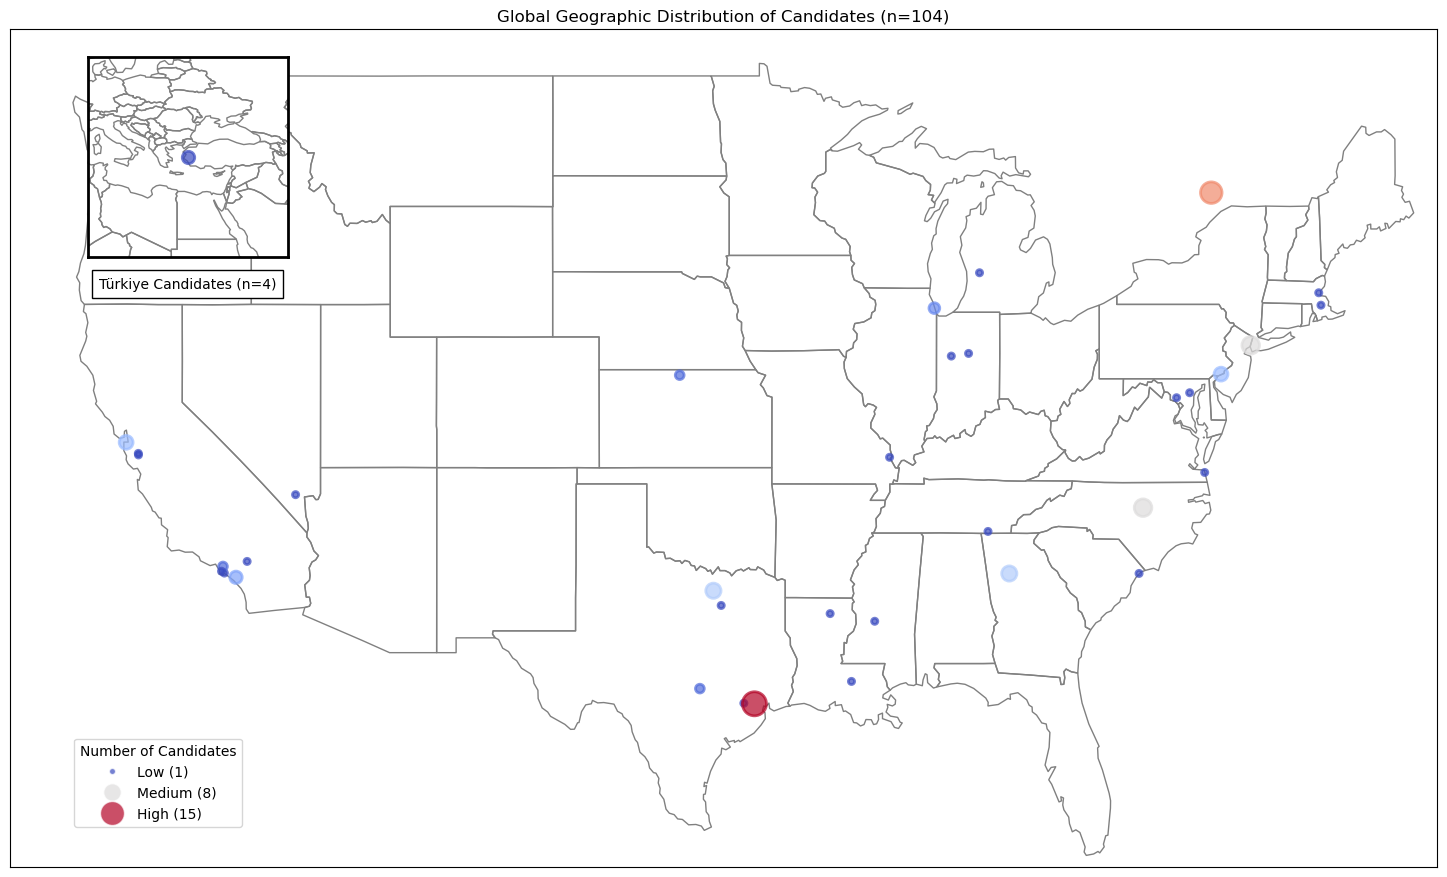

In [148]:
# set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))
plt.title(f'Global Geographic Distribution of Candidates (n={df.shape[0]})') 
plt.tight_layout()

# hide x and y axis labels for cleaner map display
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# plot US states
states.plot(ax=ax, edgecolor='grey', facecolor='none')

# plot scatter points for North America data
scale_factor = 20  # to make it more visible
alpha_ = 0.7  # consistent alpha value
cmap='coolwarm'

scatter_na = ax.scatter(
    x=ct_cities_na['lon'], 
    y=ct_cities_na['lat'],
    s=ct_cities_na['ct'] * scale_factor,
    c=ct_cities_na['ct'],
    cmap=cmap,
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused map view on North America
ax.set_xlim([ct_cities_na['lon'].min() - 5, ct_cities_na['lon'].max() + 5])
ax.set_ylim([ct_cities_na['lat'].min() - 5, ct_cities_na['lat'].max() + 5])

## add inset for Türkiye data
axins = inset_axes(ax, width=3, height=2, loc='upper left', borderpad=2)
axins.text(
    0.5, -0.1,                   # X, Y coordinates (centered below the inset)
    f"Türkiye Candidates (n={ct_cities_tk['ct'][0]})",         # Text content
    ha='center', va='top',        # Horizontal and vertical alignment
    transform=axins.transAxes,    # Transform relative to axins' coordinates
    fontsize=10,                  # Adjust font size as desired
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5')  # White background with rounded edges
)
axins.spines['top'].set_linewidth(2)
axins.spines['bottom'].set_linewidth(2)
axins.spines['left'].set_linewidth(2)
axins.spines['right'].set_linewidth(2)
axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)

# plot the borders of Türkiye's neighboring countries
borders.plot(ax=axins, edgecolor='grey', facecolor='none')

# plot scatter points for Türkiye data in the inset
scatter_tk = axins.scatter(
    x=ct_cities_tk['lon'], 
    y=ct_cities_tk['lat'],
    s=ct_cities_tk['ct'] * scale_factor,
    c=ct_cities_tk['ct'],
    cmap=cmap,
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused view of Türkiye in the inset
axins.set_xlim([ct_cities_tk['lon'].min() - 20, ct_cities_tk['lon'].max() + 20])
axins.set_ylim([ct_cities_tk['lat'].min() - 20, ct_cities_tk['lat'].max() + 20])

## custom legend entries using Line2D
# define representative sizes and values for legend
min_ = min(ct_cities_na['ct'])
max_ = max(ct_cities_na['ct'])
middle = (min_ + max_) / 2

size_labels = [min_, middle, max_]
colors = [min_, middle, max_]

# use color map to assign color to each representative count
cmap = plt.cm.coolwarm
color_legend = [cmap((value - min_) / (max_ - min_)) for value in colors]

# create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Low ({min_})', 
#            using square root so that the marker size area scales appropriately with original scale factor
           markerfacecolor=color_legend[0], markersize=(size_labels[0] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'Medium ({middle:.0f})', 
           markerfacecolor=color_legend[1], markersize=(size_labels[1] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'High ({max_})', 
           markerfacecolor=color_legend[2], markersize=(size_labels[2] * scale_factor) ** 0.5, alpha=alpha_)
]

# add the custom legend to the plot
ax.legend(handles=legend_elements, 
          title="Number of Candidates", 
          loc="lower left", 
          frameon=True,
          bbox_to_anchor=(0.04,0.04))

plt.savefig('figures/3_map.pdf',bbox_inches='tight')
plt.savefig('figures/3_map.jpg',bbox_inches='tight')
plt.savefig('figures/3_map.png',bbox_inches='tight')

plt.show()

In [149]:
print(f"Candidates in Canada: {df[df['location'].str.contains('anada')].shape[0]}")
print(f"Candidates in Türkiye: {df[df['location'].str.contains('rkiye')].shape[0]}")
print(f"Candidates in US: {df.shape[0] - df[df['location'].str.contains('anada|urky')].shape[0]}")

Candidates in Canada: 12
Candidates in Türkiye: 4
Candidates in US: 92


Most candidates are based in the US (n=92), with a small minority based in Canada (n=12) or Türkiye (n=4).

## Preprocess Language Data

In [150]:
df.head(3)

,id,job_title,location,connection,lat,lon,name
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh


In [151]:
print(df['job_title'].sample().values)

['Director Human Resources  at EY']


### Vectorize `job_title` column

### Define preprocessor

This preprocessor will standardize the English words so that they can be analyzed truthfully, allowing us to know that when more candidates are added to the dataset, their job titles will be processed similarly.

#### Version of dataset with lemmatization

In [152]:
def preprocessor_lemma(text):
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    
    lemmatizer=WordNetLemmatizer()
    
    # list of English stopwords in lowercase
    stops=set(stopwords.words('english'))
    
    # break into sentences to get parts-of-speech (pos) tagging to word best
    as_sent=sent_tokenize(text,language='english')
    processed=[]
    
    for sent in as_sent:
        # break each sentence into words
        tokens=word_tokenize(sent)
        
        # get pos tags for lemmatization
        pos_tags=nltk.pos_tag(tokens)
        mapped_tags=[(tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags]
        lemmas=[lemmatizer.lemmatize(*tagged) for tagged in mapped_tags]
        
        # convert to lower after lemmatization
        as_str=' '.join([lemma.lower() for lemma in lemmas])
        
        # remove unwanted punctuation. keeping numbers because it may prove valuable to have years
        cleaned=''.join([char for char in as_str if char in 'abcdefghijklmnopqrstuvwxyz 0123456789'])
        
        # double-check no empty strings and add to processed
        cleaned=[word for word in cleaned.split() if len(word) > 0 and word not in stops]
        processed.extend(cleaned)
        
    return ' '.join(processed)

In [153]:
# mapping for parts-of-speech tags
pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}

In [154]:
# instantiate vectorizor
vec=TfidfVectorizer(preprocessor=preprocessor_lemma)
tfidf=vec.fit_transform(df['job_title'])

# get feature names to use as DataFrame columns
feature_names=vec.get_feature_names_out()
df_job_titles_lemma=pd.DataFrame(tfidf.toarray(),columns=feature_names)

print(df_job_titles_lemma.shape)
df_job_titles_lemma.head(3)

(104, 185)


,2019,2020,408,7092621,administration,administrative,admissions,advisory,always,america,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.311616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Version of processed dataset without lemmatization

In [155]:
def preprocessor_nolem(text):
    
    # List of English stopwords in lowercase
    stops = set(stopwords.words('english'))
    
    # Break into sentences
    as_sent = sent_tokenize(text, language='english')
    processed = []
    
    for sent in as_sent:
        # Tokenize each sentence
        tokens = word_tokenize(sent)
        
        # Convert each word to lowercase directly
        tokens_lower = [token.lower() for token in tokens]
        
        # Remove punctuation, keeping only alphanumeric characters
        cleaned = ''.join([char for char in ' '.join(tokens_lower) if char in 'abcdefghijklmnopqrstuvwxyz 0123456789'])
        
        # Filter out stopwords and empty strings
        cleaned = [word for word in cleaned.split() if len(word) > 0 and word not in stops]
        processed.extend(cleaned)
        
    return ' '.join(processed)

In [156]:
# mapping for parts-of-speech tags
pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}

In [157]:
# instantiate vectorizor
vec=TfidfVectorizer(preprocessor=preprocessor_nolem)
tfidf=vec.fit_transform(df['job_title'])

# get feature names to use as DataFrame columns
feature_names=vec.get_feature_names_out()
df_job_titles=pd.DataFrame(tfidf.toarray(),columns=feature_names)

print(df_job_titles.shape)
df_job_titles.head(3)

(104, 182)


,2019,2020,408,7092621,administration,administrative,admissions,advisory,always,america,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.321105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Figure of Most Common Words

In [158]:
job_title_list=[]

for index,job in enumerate(df['job_title']):
    if index%10==0:
        print('Processed',index, f"rows, {index/df['job_title'].count()*100:.2f}% complete.")
    cleaned=preprocessor_lemma(job)
    job_title_list.extend(cleaned.split()) # add words, not letters
print(f"Processed all {df['job_title'].shape[0]} rows.")
job_title_counts=Counter(job_title_list)
print(job_title_counts.most_common(10))

Processed 0 rows, 0.00% complete.
Processed 10 rows, 9.62% complete.
Processed 20 rows, 19.23% complete.
Processed 30 rows, 28.85% complete.
Processed 40 rows, 38.46% complete.
Processed 50 rows, 48.08% complete.
Processed 60 rows, 57.69% complete.
Processed 70 rows, 67.31% complete.
Processed 80 rows, 76.92% complete.
Processed 90 rows, 86.54% complete.
Processed 100 rows, 96.15% complete.
Processed all 104 rows.
[('human', 63), ('resources', 63), ('aspiring', 27), ('professional', 20), ('student', 16), ('college', 14), ('generalist', 14), ('university', 12), ('specialist', 12), ('business', 11)]


In [159]:
job_title_t10=job_title_counts.most_common(10)

word_,count_=zip(*job_title_counts.most_common(10))

word_=list(word_)
count_=list(count_)

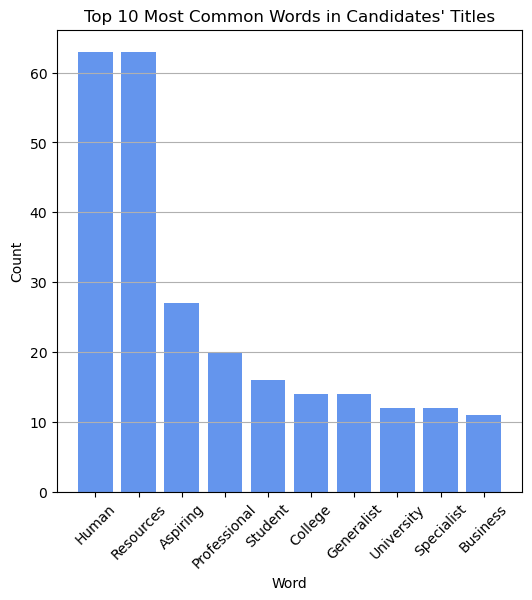

In [160]:
# make title case
word_t=[word.title() for word in word_]

plt.figure(figsize=(6,6))
plt.tight_layout()
plt.bar(x=word_t,height=count_,color='cornflowerblue')
plt.title("Top 10 Most Common Words in Candidates' Titles")
plt.xticks(rotation=45)
plt.grid(visible=True,which='major',axis='y')
plt.ylabel('Count')
plt.xlabel('Word')

plt.savefig('figures/3_top10words.pdf',bbox_inches='tight')
plt.savefig('figures/3_top10words.jpg',bbox_inches='tight')
plt.savefig('figures/3_top10words.png',bbox_inches='tight')

plt.show()

In [161]:
count_[0]/df.shape[0]

0.6057692307692307

We can see that over 60% of candidates have the words "Human" and "Resources" in their job titles.

#### Word Cloud of the Job Titles

In [210]:
jobs=[df['job_title']]

jobs

[0      2019 C.T. Bauer College of Business Graduate (...
 1      Native English Teacher at EPIK (English Progra...
 2                  Aspiring Human Resources Professional
 3                 People Development Coordinator at Ryan
 4        Advisory Board Member at Celal Bayar University
                              ...                        
 99     Aspiring Human Resources Manager | Graduating ...
 100                Human Resources Generalist at Loparex
 101     Business Intelligence and Analytics at Travelers
 102                       Always set them up for Success
 103     Director Of Administration at Excellence Logging
 Name: job_title, Length: 104, dtype: object]

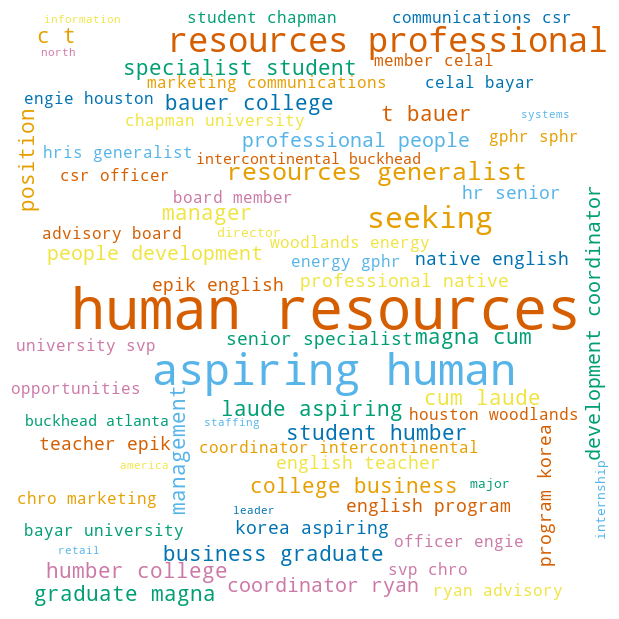

In [216]:
# taken from GeeksForGeeks.org:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Define list of job titles
jobs = df['job_title'].tolist()
# jobs=[df['job_title']]

comment_words = ''
stopwords = set(STOPWORDS)
 
# Iterate through each job title
for job in jobs:
    # Typecast each job title to string and split into tokens by spaces
    job = str(job)
    tokens = job.split()  # Split each title into individual words
    
    # Convert each token into lowercase and add to comment_words if not a stopword
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    
    # Join tokens to build the complete comment_words string with individual words
    comment_words += " ".join(tokens) + " "
    
# Define the colorblind-friendly palette
colorblind_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Custom color function to apply colorblind-friendly colors
def colorblind_friendly_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colorblind_palette)
    
# Create the word cloud
cloud = WordCloud(width=600, 
                  height=600,
                  background_color='white',
                  stopwords=stopwords,
                  min_font_size=10,
                  color_func=colorblind_friendly_color_func).generate(comment_words)
 
# Plot the WordCloud image                       
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(cloud,interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Save the word cloud as different file formats
plt.savefig('figures/3_wordcloud.pdf')
plt.savefig('figures/3_wordcloud.jpg')
plt.savefig('figures/3_wordcloud.png')

plt.show()

This is more for show, but we can see that "human","resources", and "aspiring" all appear frequently in the dataset.

## Calculate Cosine Similarity with the Search Terms

As a reminder, we are currently helping the company understand which candidates are a best fit for their human resources position. As such, the company is focusing on two search terms:
* **"Aspiring human resources"**, or
* **"Seeking human resources"**

We will pretend that the company is initializing their search terms by creating a parquet file using the following code. I'm using a Mac, so this is in Terminal:

```bash
python -c "import pandas as pd; df = pd.DataFrame({'term': ['Aspiring human resources', 'Seeking human resources']}); df.to_parquet('search_terms.parquet', engine='pyarrow')"
```

To edit the parquet file, I am using the following code. You can update the "ADD NEW SEARCH TERM HERE" as needed:
```bash
python -c "import pandas as pd; df = pd.read_parquet('search_terms.parquet', engine='pyarrow'); new_row = pd.DataFrame({'term': ['ADD NEW SEARCH TERM HERE']}); df = pd.concat([df, new_row], ignore_index=True); df.to_parquet('search_terms.parquet', engine='pyarrow')"

```

As the company updates their search term parquet file, we will upload a fresh file by running the code below.

In [180]:
search_dict=pd.read_parquet('search_terms.parquet')

search_term_df=pd.DataFrame.from_dict(search_dict)

# view the search term file
search_term_df

,term
0,Aspiring human resources
1,Seeking human resources


We will use the same preprocessor as above, without lemmatization, and will use the **cosine similarity** to determine the similarity between the job titles and the search terms.

In [181]:
df.head(3)

,id,job_title,location,connection,lat,lon,name,avg_sim_score
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston,0.192527
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada,0.000000
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892


In [182]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.corpus import stopwords # lists of stopwords
from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer # basic stemmer
from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/sra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [183]:
# vectorize the job_titles
# instantiate vectorizor and vectorize phrases
vec=TfidfVectorizer(preprocessor=preprocessor_nolem)
vec.fit(df['job_title']) # fit on entire job title data

# transform job titles and target phrases
df_job_titles_tfidf=vec.transform(df['job_title']) # matrix of candidate job titles
search_terms=vec.transform(search_term_df['term']) # matrix of search phrases

In [184]:
# calculate cosine similarity
sim_aspiring=cosine_similarity(df_job_titles_tfidf,search_terms[0]) # for aspiring
sim_seeking=cosine_similarity(df_job_titles_tfidf,search_terms[1])  # for seeking

In [185]:
# combine similarities into single score (maximum similarity for each candidate)
max_sim=pd.DataFrame({
    'candidate':df['id'],
    'sim_aspiring':sim_aspiring.flatten(),
    'sim_seeking':sim_seeking.flatten()
})

# max_sim['max_sim']=max_sim[['sim_aspiring','sim_seeking']].max(axis=1)
# better: highest average similarity score
max_sim['avg']=(max_sim['sim_aspiring']+max_sim['sim_seeking'])/2

# sort candidates by similarity score
# closest_candidates=max_sim.sort_values(by='max_sim',ascending=False)
closest_candidates=max_sim.sort_values(by = 'avg', ascending = False)
closest_candidates.head(10)

,candidate,sim_aspiring,sim_seeking,avg
72,73,0.576794,0.620589,0.598691
45,46,0.753591,0.326192,0.539892
57,58,0.753591,0.326192,0.539892
16,17,0.753591,0.326192,0.539892
32,33,0.753591,0.326192,0.539892
96,97,0.753591,0.326192,0.539892
2,3,0.753591,0.326192,0.539892
20,21,0.753591,0.326192,0.539892
35,36,0.695679,0.301125,0.498402
5,6,0.695679,0.301125,0.498402


In [186]:
# tuple as the order matters
top10_candidates=tuple(closest_candidates.head(10)['candidate'])
top10_candidates

(73, 46, 58, 17, 33, 97, 3, 21, 36, 6)

### Top 10 Candidates

In [187]:
if 'avg_sim_score' not in df.columns: # flow control to prevent double columns
    # add avg sim score to df
    df = df.join(max_sim['avg'])

    # rename column
    df.rename(columns={'avg':'avg_sim_score'},inplace=True)

    # make it look nice
    df_= df.copy()
    df_['avg_sim_score'] = (df_['avg_sim_score'] * 100).round(2).astype(str) + '%'

    # order by sim score (using candidates id from a previous cell)
    df_['id'] = pd.Categorical(df_['id'], categories=closest_candidates['candidate'], ordered = True)
    sorted_df_hero = df_.sort_values('id')

sorted_df_hero[['id','job_title','connection','name','avg_sim_score']].head(10)

,id,job_title,connection,name,avg_sim_score
72,73,"Aspiring Human Resources Manager, seeking inte...",7,Houston,59.87%
45,46,Aspiring Human Resources Professional,44,Raleigh,53.99%
57,58,Aspiring Human Resources Professional,44,Raleigh,53.99%
16,17,Aspiring Human Resources Professional,44,Raleigh,53.99%
32,33,Aspiring Human Resources Professional,44,Raleigh,53.99%
96,97,Aspiring Human Resources Professional,71,Kokomo_IN,53.99%
2,3,Aspiring Human Resources Professional,44,Raleigh,53.99%
20,21,Aspiring Human Resources Professional,44,Raleigh,53.99%
35,36,Aspiring Human Resources Specialist,1,New_York_City,49.84%
5,6,Aspiring Human Resources Specialist,1,New_York_City,49.84%


These are the top-10 likeliest candidate IDs for the human resource position!

## Dense Word Embeddings with Word2Vec

To perform a dense word embedding with Word2Vec, we will use the following process:
1. Load a pre-trained Word2Vec model
1. Average the word vectors
1. Compute average vectors for `job_title` and `search_term`
1. Calculate similarity scores

### 1. Load Word2Vec model

In [222]:
# downloaded from Kaggle:
# https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
model = KeyedVectors.load_word2vec_format(fname='../data/GoogleNews-vectors-negative300.bin',binary=True)

### 2. Average the Word Vectors

We'll have to create a function to do so:

In [223]:
def get_average_vector(text, model):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    
    # Filter words in vocabulary and not stopwords
    valid_words = [word for word in words if word in model and word not in stop_words]
    
    if not valid_words:  # if there are no valid words, return a zero vector
        return np.zeros(model.vector_size)
    
    # Average vectors for all valid words in the text
    word_vectors = np.array([model[word] for word in valid_words])
    average_vector = word_vectors.mean(axis=0)
    
    return average_vector

This function does the following:
1. Converts the text to lowercase
1. Tokenizes the text
1. Filters out stopwords and words not in the Word2Vec vocabulary
1. Produces a single vector for the text based on the mean of each vector

### 3. Compute Average Vectors for Job Titles and Search Terms

In [ ]:
# compute vector for each job title
df['job_title_vector'] = df['job_title'].apply(lambda x: get_average_vector(x, model))

# get vectors for search terms
search_term_vectors=[get_average_vector(term, model) for term in search_term_df['term']]

In [ ]:
# Calculate similarity scores for each candidate
df['similarity_to_aspiring'] = df['job_title_vector'].apply(lambda x: cosine_similarity([x], [phrase_vectors[0]])[0][0])
df['similarity_to_seeking'] = df['job_title_vector'].apply(lambda x: cosine_similarity([x], [phrase_vectors[1]])[0][0])

# Get maximum similarity score for each job title
df['max_similarity'] = df[['similarity_to_aspiring', 'similarity_to_seeking']].max(axis=1)

# Sort by similarity to find closest candidates
closest_candidates = df.sort_values(by='max_similarity', ascending=False)

# Display top results
print(closest_candidates[['job_title', 'max_similarity']].head())